In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Loading the data

In [2]:
data = pd.read_csv('AB_NYC_2019.csv')
print(data.shape)
data.head()

(48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


Let's find out if there are any `NaN` or `Null` values in the dataset

In [3]:
data.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [4]:
data.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

There are several ways to handle these missing values, such as: 
- replacing them by the mean or median value of the field
- random value from the range
<br>or when the dataset is relatively large, we can simply delete the entire row:
- ignoring the whole entry

but in this case we fill the blanks with the most repeated value of that field (mode).
<br>Also for the sake of simplicity and respecting the privacy of the hosts, first we drop these columns:

In [5]:
data.drop(['name', 'id', 'host_name'], axis=1, inplace=True)

In [6]:
nan_cols = ['last_review', 'reviews_per_month']
for col in nan_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)
    if data[col].dtype!='O':
        data[col].replace(0, data[col].mean(), inplace=True)

data.isnull().sum()

host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
last_review                       0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   host_id                         48895 non-null  int64  
 1   neighbourhood_group             48895 non-null  object 
 2   neighbourhood                   48895 non-null  object 
 3   latitude                        48895 non-null  float64
 4   longitude                       48895 non-null  float64
 5   room_type                       48895 non-null  object 
 6   price                           48895 non-null  int64  
 7   minimum_nights                  48895 non-null  int64  
 8   number_of_reviews               48895 non-null  int64  
 9   last_review                     48895 non-null  object 
 10  reviews_per_month               48895 non-null  float64
 11  calculated_host_listings_count  48895 non-null  int64  
 12  availability_365                

With the `describe()` method we can have a nice overview of the numerical column of the dataset. In this case we drop some columns that don't have numerical value.

In [8]:
data.drop(['host_id', 'latitude', 'longitude'], axis=1).describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,152.720687,7.029962,23.274466,1.095022,7.143982,112.781327
std,240.154170,20.510550,44.550582,1.594493,32.952519,131.622289
min,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000
max,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


It is clear that the rent for any type accommodation is not equal to zero, and those that are not available to rent on any day of a year are of no interest, so we drop them first. <br>Have a look at the max value and the 75% of the `minimum_nights` and `price` columns. In these columns there are certainly values that would violate the assumptions for the statistical tests, so the next step is to remove outliers to have a homogenous dataset. We do so by removing entries that are more than 3 standard deviations from the mean.

In [9]:
from scipy.stats import zscore

z_scores = zscore(data['price'])
np.append(zscore(data['minimum_nights']), z_scores)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
data = data[filtered_entries]
data = data[data['price']>0]
data = data[data['availability_365']>0]

# Normality Test
As a preprocessing step, it is better to transform values of a field that don't have a normal distribution, if possible. There are several methods that transforms distributions, i.e. skewed dist., to a normal one, such as:<br>
- Yeo-Johnson<br>
$x_i^{(\lambda)} =\begin{cases}[(x_i + 1)^\lambda - 1] / \lambda & \text{if } \lambda \neq 0, x_i \geq 0, \\[8pt]\ln{(x_i + 1)} & \text{if } \lambda = 0, x_i \geq 0 \\[8pt]-[(-x_i + 1)^{2 - \lambda} - 1] / (2 - \lambda) & \text{if } \lambda \neq 2, x_i < 0, \\[8pt]- \ln (- x_i + 1) & \text{if } \lambda = 2, x_i < \end{cases}$
- Box-Cox<br>
$x_i^{(\lambda)} =\begin{cases}\dfrac{x_i^\lambda - 1}{\lambda} & \text{if } \lambda \neq 0, \\[8pt]\ln{(x_i)} & \text{if } \lambda = 0,\end{cases}$
- Logarithm


# Skewness
In statistics, skewness is a measure of the asymmetry of the probability distribution of a random variable about its mean. In other words, skewness tells you the amount and direction of skew (departure from horizontal symmetry). The skewness value can be positive or negative, or even undefined. If skewness is 0, the data are perfectly symmetrical, although it is quite unlikely for real-world data. As a general rule of thumb: If skewness is less than -1 or greater than 1, the distribution is highly skewed. If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed. If skewness is between -0.5 and 0.5, the distribution is approximately symmetric. <br>
$\frac{\frac{1}{n}\Sigma^{n}_{i=1}(x_{i}-\bar{x})^{3}}{(\frac{1}{n}\Sigma^{n}_{i=1}(x_{i}-\bar{x})^{2})^{3/2}}$
<br>Here, x̄ is the sample mean.

# Kurtosis

Kurtosis tells you the height and sharpness of the central peak, relative to that of a standard bell curve.<br>
$\frac{\frac{1}{n}\Sigma^{n}_{i=1}(x_{i}-\bar{x})^{4}}{(\frac{1}{n}\Sigma^{n}_{i=1}(x_{i}-\bar{x})^{2})^{2}}-3$
<br>Here, x̄ is the sample mean. The "minus 3" at the end of this formula is often explained as a correction to make the kurtosis of the normal distribution equal to zero, as the kurtosis is 3 for a normal distribution.
(<a href='https://community.gooddata.com/metrics-and-maql-kb-articles-43/normality-testing-skewness-and-kurtosis-241'>source</a>)

Note: the following Normal Test is a package-defined test based on D'Agostino and Pearnson's test, developed by SciPy, and is formulated as:
<br>$s^2+k^2$<br>
where s is the z-score returned by skewtest and k is the z-score returned by kurtosistest.

In [10]:
def normal_report(data):
    import pandas as pd
    normal  = stats.normaltest(data)
    skew    = stats.skewtest(data)
    kurtosis= stats.kurtosistest(data)
    tests   = [normal, skew, kurtosis]
    names   = ['']
    res     =   pd.DataFrame({'score': normal[0], 'pvalue': normal[1]}, index=data.columns)
    for test in tests[1:]:
        temp = pd.DataFrame({f'{test.__class__.__name__}-score': test[0], f'{test.__class__.__name__}-pvalue': test[1]}, index=data.columns)
        res = res.join(temp)
    return res

Raw data:


,score,pvalue,SkewtestResult-score,SkewtestResult-pvalue,KurtosistestResult-score,KurtosistestResult-pvalue
price,15438.202472,0.0,104.375015,0.000000e+00,67.409633,0.0
minimum_nights,69228.991147,0.0,230.696645,0.000000e+00,126.522920,0.0
number_of_reviews,20388.912837,0.0,118.836145,0.000000e+00,79.163650,0.0
reviews_per_month,23466.994229,0.0,117.389137,0.000000e+00,98.421464,0.0
calculated_host_listings_count,35716.921354,0.0,161.055638,0.000000e+00,98.883785,0.0
availability_365,204487.718312,0.0,9.459196,3.103188e-21,452.104238,0.0


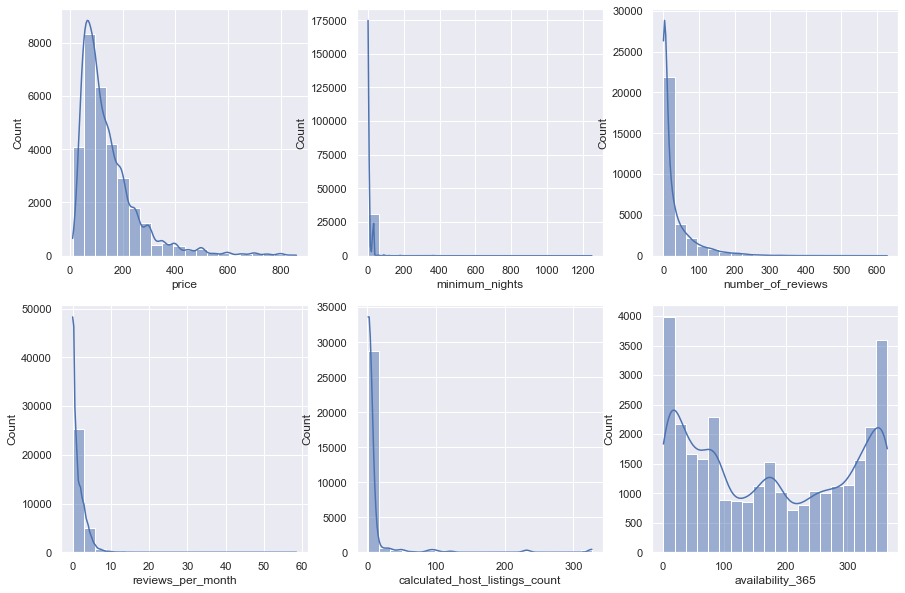

In [11]:
sns.set(rc={'figure.figsize':(15,10)})
fig, axs = plt.subplots(2, 3)
plot_cols = ['price', 'minimum_nights',	'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count',	'availability_365']
for i in [0,1,2]:
    for j in [0,1]:
        sns.histplot(data=data[plot_cols], x=plot_cols[i+j*3], bins=20, ax=axs[j, i], kde=True)

from scipy import stats
# plot_cols = ['price']
print('Raw data:')
normal_report(data[plot_cols]).head(10)

As the plots and more importantly the statistical tests show, none of these columns follow a normal distributions. Therefore, we apply the aforementioned transformations so that they form a normal distribution.

Log transformed data:
|                                |     score |      pvalue |   SkewtestResult-score |   SkewtestResult-pvalue |   KurtosistestResult-score |   KurtosistestResult-pvalue |
|:-------------------------------|----------:|------------:|-----------------------:|------------------------:|---------------------------:|----------------------------:|
| price                          |   390.211 | 1.84789e-85 |               16.8914  |             5.20201e-64 |                   -10.2416 |                 1.29061e-24 |
| minimum_nights                 |  3995.06  | 0           |               62.2783  |             0           |                    10.7921 |                 3.75139e-27 |
| number_of_reviews              | 38615.2   | 0           |                4.73889 |             2.14893e-06 |                  -196.45   |                 0           |
| reviews_per_month              |  4415.47  | 0           |              -44.0505  |             0           |            

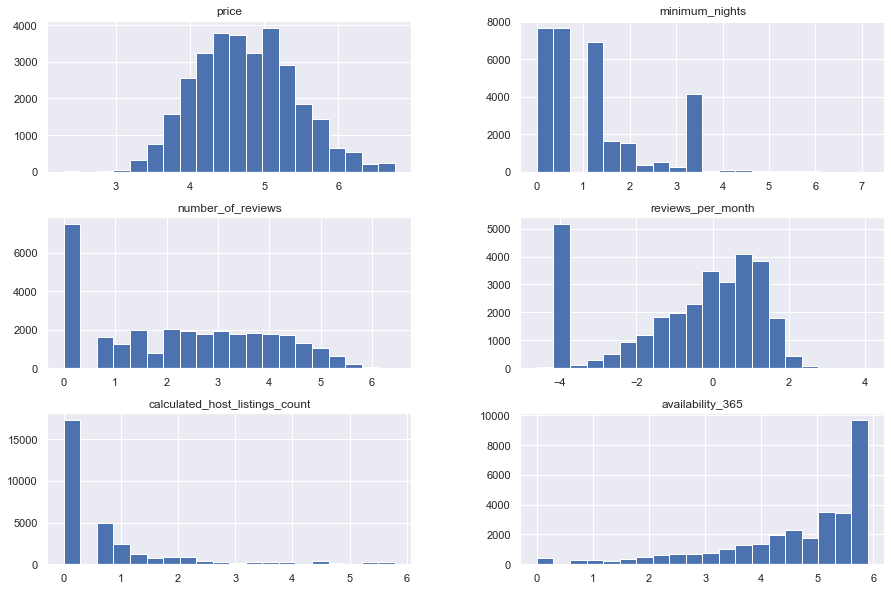

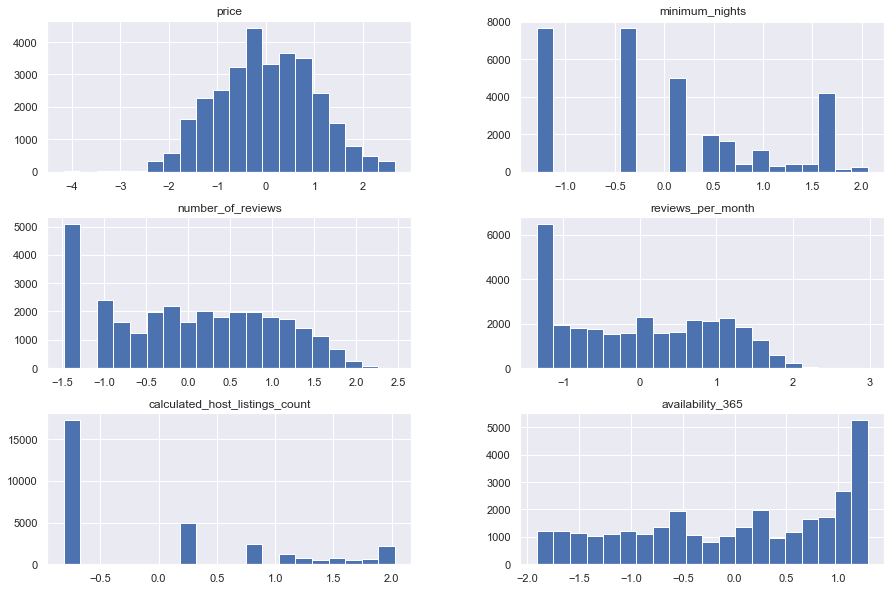

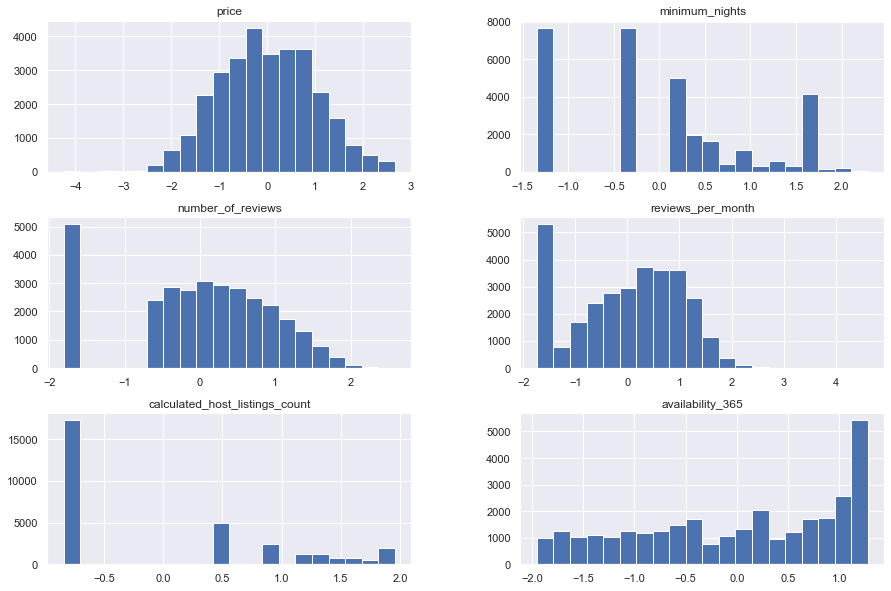

In [12]:
from sklearn.preprocessing import PowerTransformer

log_transform   = pd.DataFrame(np.log(data[plot_cols]), columns=plot_cols)
log_transform.number_of_reviews.replace(-np.inf, 0, inplace=True)
yeo_johnson = pd.DataFrame(PowerTransformer(method='yeo-johnson').fit_transform(data[plot_cols].add(0.00001)), columns=plot_cols)
box_cox = pd.DataFrame(PowerTransformer(method='box-cox').fit_transform(data[plot_cols].add(0.00001)), columns=plot_cols)



log_transform.hist(bins=20)
print('Log transformed data:')
print(normal_report(log_transform).head(10).to_markdown())

yeo_johnson.hist(bins=20)
print('Yeo-Johnson transformed data:')
print(normal_report(yeo_johnson).head(10).to_markdown())

box_cox.hist(bins=20)
print('Box-Cox transformed data:')
print(normal_report(box_cox).head(10).to_markdown())

By observing the results and plots of distributions, we can see that they still are not normal, but after transformations, they are closer to the normal distributions. Further progress can be made by removing some specific data that are causing trouble.

The following is to compare the results and the graph of a normal distribution and those that we had.

normalTest:	NormaltestResult(statistic=0.8164538735143994, pvalue=0.6648279877940435)
skewTest:	SkewtestResult(statistic=0.7027089559004347, pvalue=0.48223714524867656)
kurtosisTest:	KurtosistestResult(statistic=0.5680264050303651, pvalue=0.5700170385043334)


<AxesSubplot:ylabel='Count'>

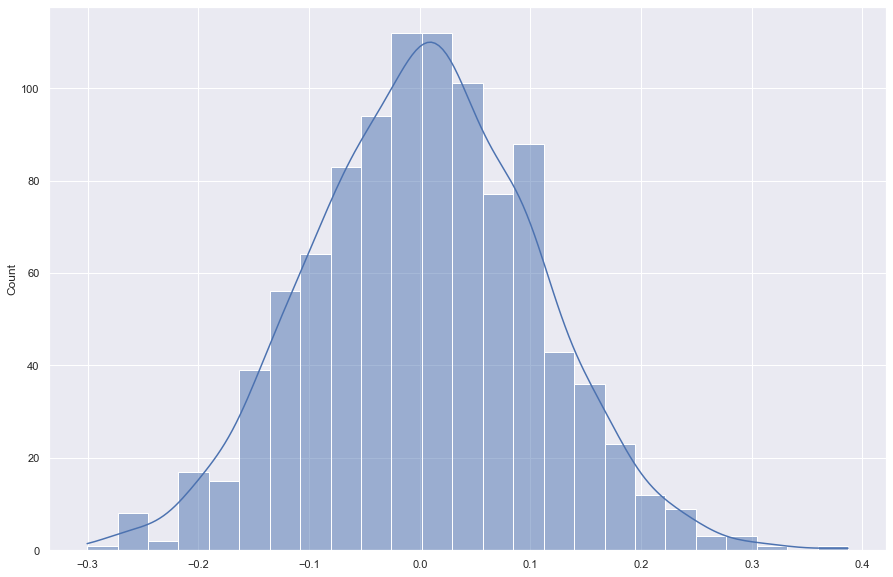

In [13]:
mu, sigma = 0, 0.1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
print('normalTest:', stats.normaltest(s), sep='\t')
print('skewTest:', stats.skewtest(s), sep='\t')
print('kurtosisTest:', stats.kurtosistest(s), sep='\t')
sns.histplot(s, kde=True)

Now it's time to deal with the geographic information, like latitude and longitude and neighbourhood details.<br>
We can derive new a column, `density`, from the given geographical coordinations to illustrate a heatmap-like graph of the density of accommodations. This density column is a kernel-density estimate of the given coordinates using gaussian kernels and is calculated by scipy's `gaussian_kde` class. Also the size of each circle is relative to that home's price.

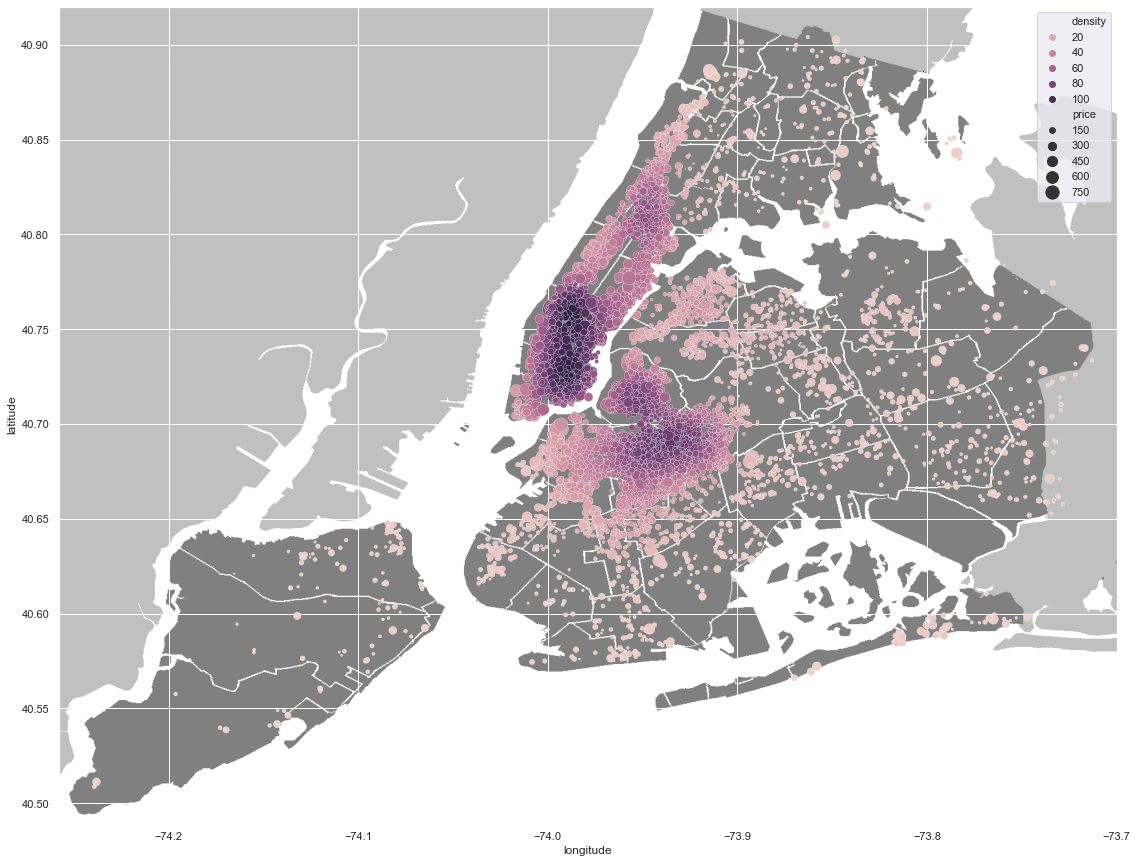

In [14]:
from scipy.stats import gaussian_kde
plt.figure(figsize=(20,15))

xy = np.vstack([data.longitude, data.latitude])
z = gaussian_kde(xy)(xy)
data['density'] = z

nyc_img=plt.imread('Neighbourhoods_New_York_City_Map.png')
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
sample = data.sample(10000)
sns.scatterplot(x=sample['longitude'], y=sample['latitude'], hue=sample.density, size=sample.price, sizes=(1, 200))
plt.legend()

Here we use a pie chart to demonstrate distributions of Airbnb listings among 5 major neighbourhood groups.

(-1.1212892274119892,
 1.1091298492131343,
 -1.1308905501493505,
 1.206175246923361)

<Figure size 1440x1080 with 0 Axes>

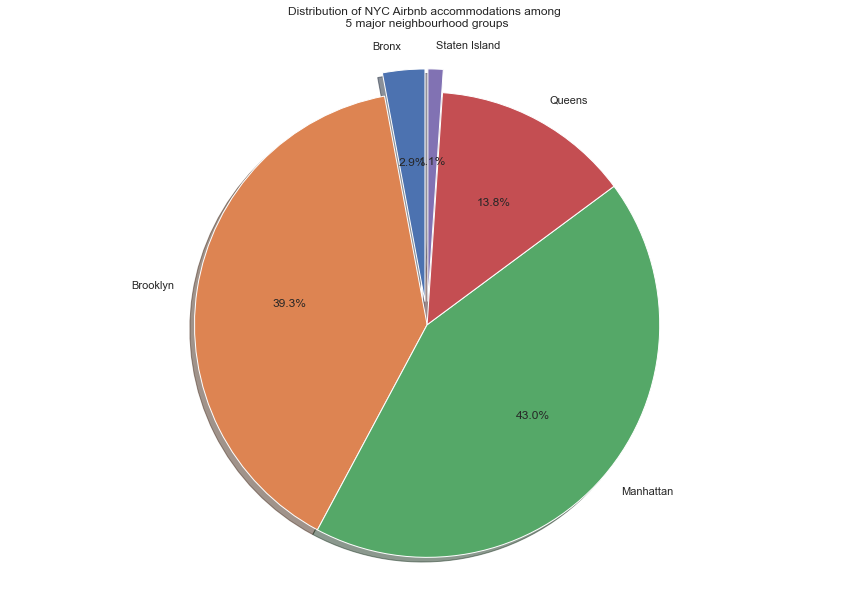

In [15]:
temp = data.groupby('neighbourhood_group')['host_id'].agg(['count'])
labels = temp.index.values
sizes = [i/temp['count'].sum() for i in temp['count']]
explode = (0.1, 0, 0, 0, 0.1)
plt.figure(figsize=(20,15))
fig1, ax1 = plt.subplots()
plt.title('Distribution of NYC Airbnb accommodations among \n 5 major neighbourhood groups\n')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

Next we group the dataste by `neighbourhood` to plot the average price in each one.

In [16]:
from collections import OrderedDict

n_g = [(i,j) for i, j in zip(data.neighbourhood, data.neighbourhood_group)]
n_g = set(n_g)
n_g = {i[0]:i[1] for i in n_g}
n_g = OrderedDict(sorted(n_g.items(), key=lambda t: t[0]))

neighborhood_df = data.groupby('neighbourhood').mean()
neighborhood_df['group'] = list(n_g.values())
neighborhood_df.head()

,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,density,group
neighbourhood,,,,,,,,,,,
Allerton,1.056663e+08,40.865346,-73.858405,91.702703,2.189189,47.351351,1.798649,2.864865,185.783784,3.299302,Bronx
Arden Heights,2.077379e+08,40.555507,-74.185043,76.000000,12.000000,8.000000,1.150000,1.000000,125.666667,0.132183,Staten Island
Arrochar,8.173055e+07,40.593900,-74.074600,115.000000,2.761905,14.619048,1.061905,4.190476,255.809524,1.611362,Staten Island
Arverne,8.476303e+07,40.592012,-73.794902,156.694444,1.625000,30.486111,1.590556,1.694444,196.763889,3.475760,Queens
Astoria,8.078140e+07,40.764053,-73.919808,104.836996,5.846154,30.309524,1.466850,3.428571,179.152015,26.636433,Queens


<Figure size 1080x1080 with 0 Axes>

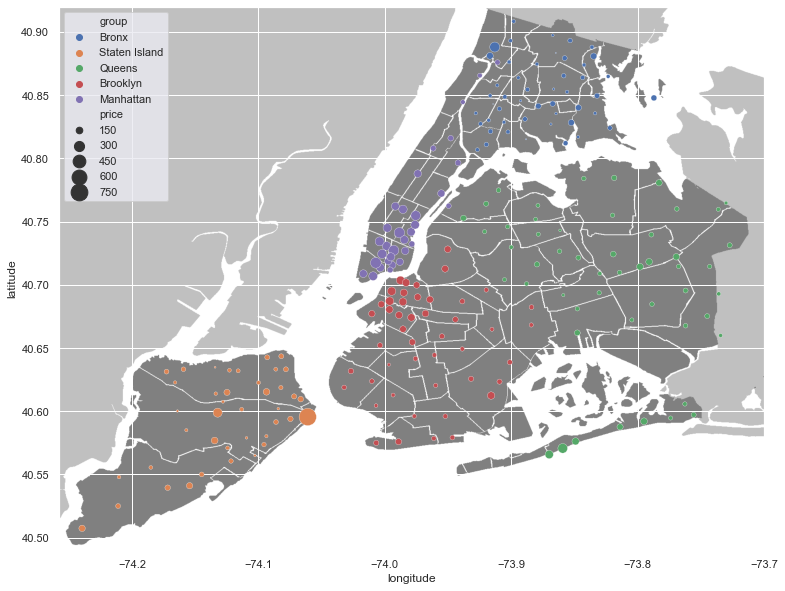

In [17]:
plt.figure(figsize=(15,15))
fig, ax1 = plt.subplots()
nyc_img=plt.imread('Neighbourhoods_New_York_City_Map.png')
ax1.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
sns.scatterplot(x=neighborhood_df['longitude'], y=neighborhood_df['latitude'], hue=neighborhood_df.group, size=neighborhood_df.price, sizes=(1, 300), ax=ax1)
plt.legend()

We can find those hosts that are the busiest by applying a threshold on the entries that have listed homes more than others. First we need to group the dataset by `host_id` to have summarized information about each one.

In [18]:
hosts = data.drop(['latitude', 'longitude'], axis=1).groupby('host_id').mean().sort_values('calculated_host_listings_count', ascending=False)
hosts.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,density
host_id,,,,,,,
219517861,253.195719,13.311927,3.917431,1.223119,327.0,301.492355,59.818851
107434423,303.150862,32.198276,0.125000,0.043621,232.0,253.810345,79.626719
30283594,257.771186,29.974576,0.550847,0.046102,121.0,314.364407,82.078826
137358866,44.369565,30.000000,0.891304,0.223478,103.0,219.967391,27.697180
12243051,213.031250,29.000000,0.447917,0.104062,96.0,276.614583,67.112668


In [19]:
hosts.describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,density
count,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,149.662725,6.873514,33.843902,1.579087,1.485125,152.727719,53.426646
std,111.975614,25.016220,50.619667,1.688689,3.612234,120.151525,31.392510
min,10.000000,1.000000,0.000000,0.010000,1.000000,1.000000,0.077169
25%,75.000000,2.000000,2.000000,0.270000,1.000000,41.000000,27.232414
50%,120.000000,2.666667,13.000000,1.000000,1.000000,128.333333,55.054562
75%,187.500000,4.000000,44.000000,2.420000,1.000000,261.000000,79.062322
max,860.000000,1250.000000,602.500000,20.940000,327.000000,365.000000,113.931857


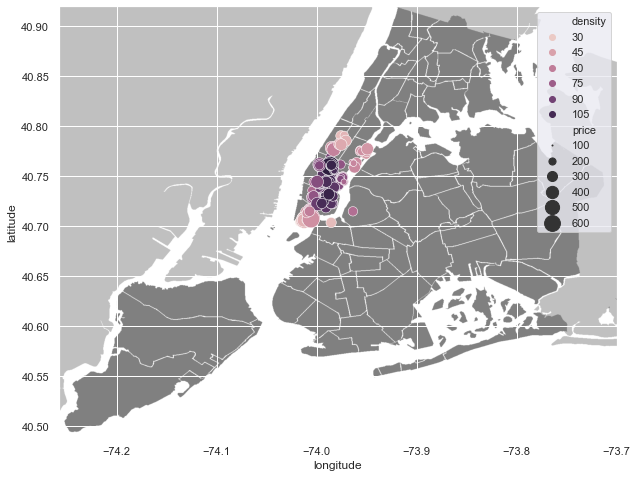

In [20]:
plt.figure(figsize=(10,10))
nyc_img=plt.imread('Neighbourhoods_New_York_City_Map.png')
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
thres  = int((hosts.calculated_host_listings_count.iloc[0]-hosts.calculated_host_listings_count.iloc[-1])*0.5)
sample = data[data.calculated_host_listings_count>thres]
sns.scatterplot(x=sample['longitude'], y=sample['latitude'], hue=sample.density, size=sample.price, sizes=(1, 300))
plt.legend()

In terms of different types of rooms, by grouping the dataset, we can see that 'price', 'minimum_nights', 'number_of_reviews', and 'calculated_host_listings_count' columns are different within each group, so we plot those.

In [21]:
home_type = data.groupby('room_type').mean()
home_type.drop(['host_id', 'latitude', 'longitude'], axis=1, inplace=True)
home_type.index.name = None
home_type.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,density
Entire home/apt,201.219373,10.329796,31.303785,1.455429,15.902521,170.961413,57.970652
Private room,86.415408,5.961157,33.729895,1.611134,4.226946,177.426557,47.932338
Shared room,62.753488,6.979070,19.201163,1.323558,5.563953,217.658140,47.182557


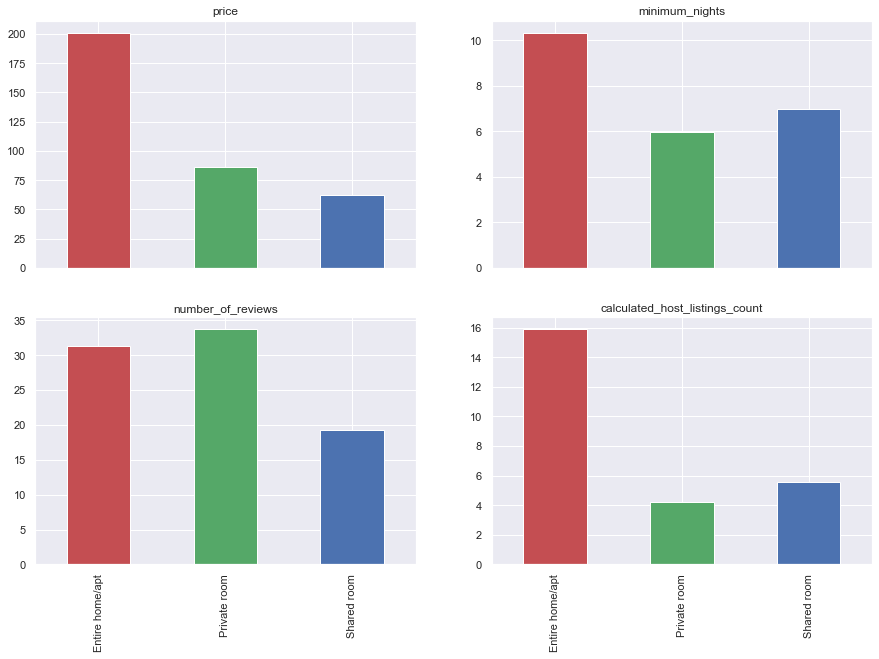

In [22]:
fig, ax = plt.subplots(2, 2)
plot_cols = ['price', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count']
ax = ax.flatten()
for num, col in enumerate(plot_cols):
    home_type[col].plot(kind='bar', ax=ax[num], sharex=True, title=col, color=['r', 'g', 'b'])

Also we can plot different types of properties located whitin major neighbourhood groups. Here we plot `calculated_host_listings_count`, `price`, and `density` columns by `sns.barplot`. By specifying the column name as `hue` parameter, you can get more detailed bars, as we'll see this for the `room_type` column.

<AxesSubplot:xlabel='neighbourhood_group', ylabel='density'>

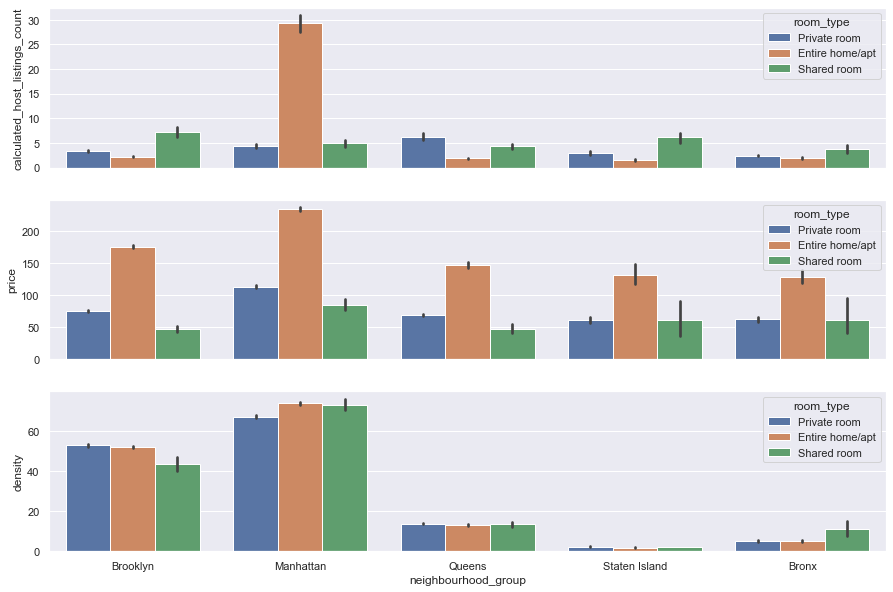

In [23]:
_, ax = plt.subplots(3,1, sharex=True)
sns.barplot(x='neighbourhood_group', y='calculated_host_listings_count', hue='room_type', data=data, ax=ax[0]).set(xlabel=None)
sns.barplot(x='neighbourhood_group', y='price', hue='room_type', data=data, ax=ax[1]).set(xlabel=None)
sns.barplot(x='neighbourhood_group', y='density', hue='room_type', data=data, ax=ax[2])

There are features in this dataset that are likely to be correlated, `reviews_per_month` and `number_of_reviews` are an obvious example. Hence by plotting the correaltion matrix, using a threshold, we can gain a nice prespective of how these variables will behave respectively. For instance, it's apparent that as the density of a place grows, the prices will consequently rise up.

<AxesSubplot:>

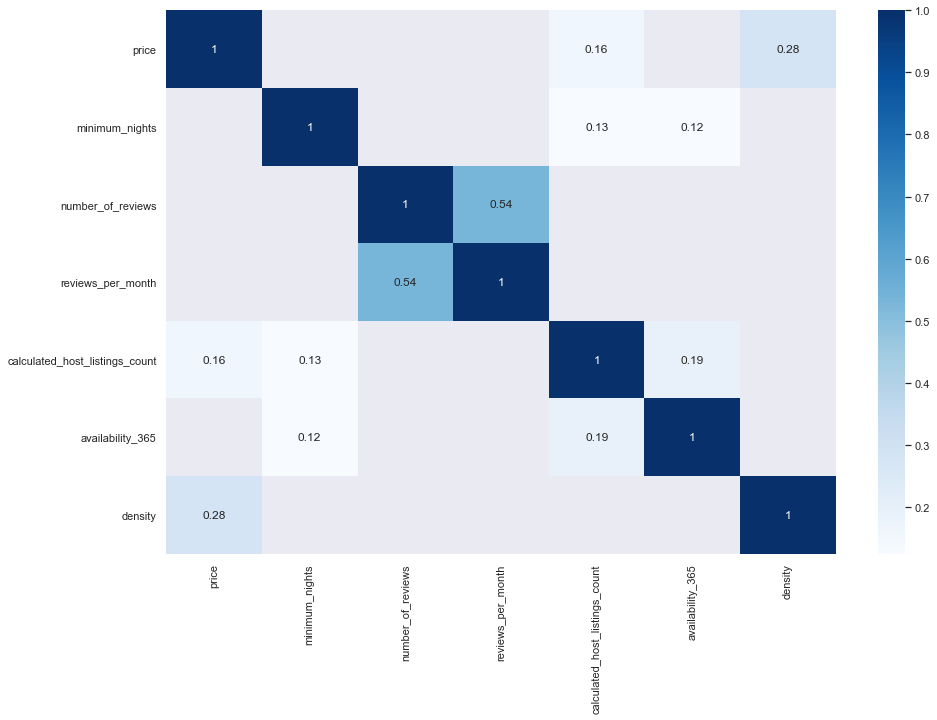

In [24]:
corr = data.drop(['latitude', 'longitude', 'host_id'], axis=1).corr()
corr = corr[corr>0.1]
sns.heatmap(corr[corr>0.1], cmap="Blues", annot=True)